In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./refined-data/eval_data.csv')
data

,DISTRICT,LOCATION,PH,EC,TDS,TH,CA,MG,NA,K,CO3,HCO3,CL,NO3,SO4,F,ALK,YEAR,SAR
0,Ahmedabad,Barvala,8.25,5090.0,3410.0,450.0,80.0,60.0,937.0,0.3,0.0,891.0,959.0,24.00,346.0,2.80,730.0,2017,NaN
1,Ahmedabad,Dhandhuka1,8.23,14210.0,9521.0,1300.0,180.0,207.0,3220.0,9.9,0.0,1013.0,3373.0,1600.00,1290.0,6.64,830.0,2017,NaN
2,Ahmedabad,Endla,8.17,685.0,459.0,220.0,52.0,22.0,49.0,13.6,0.0,305.0,50.0,2.00,2.0,0.44,250.0,2017,NaN
3,Ahmedabad,Kumarkhan,8.19,10660.0,7142.0,800.0,140.0,109.0,1875.0,7.2,0.0,988.0,2485.0,32.00,443.0,11.20,810.0,2017,NaN
4,Ahmedabad,Kundali,8.03,1300.0,871.0,280.0,64.0,29.0,210.0,3.7,0.0,305.0,85.0,230.00,171.0,0.50,250.0,2017,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,Kutchch,Desalpur,7.42,768.0,515.0,180.0,40.0,19.0,95.0,10.0,0.0,183.0,113.0,3.20,70.0,0.15,150.0,2021,3.08
2760,Kutchch,Ratanpar Khadir,7.73,4419.0,2961.0,701.0,96.0,112.0,712.0,17.0,0.0,403.0,1064.0,13.00,310.0,0.78,330.0,2021,11.70
2761,Kutchch,Rapar,7.60,2942.0,1971.0,400.0,132.0,17.0,552.0,26.0,0.0,281.0,567.0,33.00,538.0,0.93,230.0,2021,12.00
2762,Kutchch,Kuda,7.35,1464.0,981.0,410.0,104.0,36.0,125.0,18.0,0.0,610.0,142.0,0.31,25.0,1.04,500.0,2021,2.68


## :sparkles: CCME-WQI

In [3]:
drinking_water_range = {
    # "Component": [Acceptable Limit, Permissible Limit in absence of alternative source]
    "PH": [6.5, 8.5], #
    "EC": [0, 1500], #
    "TDS": [500, 2000], #
    "ALK": [200, 600], #
    "TH": [200, 600], #
    "CL": [250, 1000], #
    "CA": [75, 200], #
    "MG": [30, 100], #
    "SO4": [200, 400], #
    "NO3": [0, 45], #
    "F": [1, 1.5], #
}

In [4]:
import numpy as np

features = drinking_water_range.keys()
total_number_of_features = len(features)

def calculate_F1(df, guideline_values):
    F1 = sum(1 for feature in features if df[feature] < guideline_values[feature][0] or df[feature] > guideline_values[feature][1])
    return (F1*100)/total_number_of_features


def calculate_F2(df, guideline_values):
    F2 = sum(1 for feature in features if df[feature] > guideline_values[feature][1])
    return (F2*100)/total_number_of_features


def calculate_F3(df, guideline_values):
    F3_list = []
    for feature in features:
        F3 = 0
        if df[feature] < guideline_values[feature][0]:
            F3 = (guideline_values[feature][0] - df[feature])/guideline_values[feature][0]
        elif df[feature] > guideline_values[feature][1]:
            F3 = (df[feature] - guideline_values[feature][1])/guideline_values[feature][1]
        F3_list.append(F3)
    nse = sum(F3_list)/len(features)
    return nse/(0.01*nse + 0.01)


def calculate_WQI(df, guideline_values):
    wqi_values = []
    for idx, row in df.iterrows():
        F1 = calculate_F1(df.iloc[idx], guideline_values)
        F2 = calculate_F2(df.iloc[idx], guideline_values)
        F3 = calculate_F3(df.iloc[idx], guideline_values)
        wqi = (np.sqrt(F1*F1 + F2*F2 + F3*F3) / 1.732)  # Dividing by 1.732 to reduce the value to 100
        wqi_values.append(wqi)
    return wqi_values


# Calculating WQI for each instance
wqi_values = calculate_WQI(data, drinking_water_range)
# Adding WQI values to DataFrame
results = pd.DataFrame()
results['CCME-WQI'] = wqi_values
results['CCME-WQI'] = results['CCME-WQI'].apply(lambda x: np.abs(100-x))

In [5]:
results['CCME-WQI']

0       66.317611
1       17.470765
2       66.157842
3       30.834894
4       62.605276
          ...    
2759    60.989717
2760    57.180425
2761    75.149894
2762    87.842858
2763    77.998531
Name: CCME-WQI, Length: 2764, dtype: float64

## :sparkles: WAWQI

In [6]:
constants = pd.DataFrame({
    'features':        ['PH','EC','TDS','ALK','TH', 'F','CL','NO3','SO4','CA','MG'],
    'standard_values': [8.5 , 300, 1000,  120, 300, 1.5, 250,  45,  250,  75,  30],
    'ideal_values':    [    7,  0,    0,    0,   0,   0,   0,   0,    0,   0,   0],
})

In [7]:
def calculate_K():
    return 1/(constants['standard_values'].sum())

def calculate_qi_wi(df):
    qn = pd.DataFrame()
    qi_wi = []
    Wn = calculate_unit_weight_of_nth_parameter()

    for col in constants['features']:
        v_ideal = constants[constants['features'] == col]['ideal_values'].values[0]
        s_value = constants[constants['features'] == col]['standard_values'].values[0]
        qn[col] = 100 * ((df[col] - v_ideal) / (s_value - v_ideal))

    for row in qn.iterrows():
        qi_wi.append((np.array(row[1])*Wn).sum())
    
    qn['qi_wi'] = qi_wi

    return qn

def calculate_unit_weight_of_nth_parameter():
    Wn = []
    K = calculate_K()
    for feature in features:
        Wn.append(K/constants[constants['features'] == feature]['standard_values'])
    constants['unit_weights'] = Wn
    return Wn

def calculate_wawqi(data):
    Wn = calculate_unit_weight_of_nth_parameter()
    qn = calculate_qi_wi(data)

    wawqi = qn['qi_wi'] / np.array(Wn).sum()
    return wawqi/100

wawqi = calculate_wawqi(data)

In [8]:
results['WAWQI'] = wawqi

In [9]:
results

,CCME-WQI,WAWQI
0,66.317611,39.480000
1,17.470765,136.891889
2,66.157842,8.311444
3,30.834894,78.275111
4,62.605276,17.196111
...,...,...
2759,60.989717,7.274778
2760,57.180425,34.582556
2761,75.149894,23.527667
2762,87.842858,15.582556


## :sparkles: EBWQI

In [10]:
from sklearn.preprocessing import MinMaxScaler

data = data.drop(['DISTRICT','YEAR','LOCATION'], axis=1).reset_index(drop=True)

scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
scaled_data

,PH,EC,TDS,TH,CA,MG,NA,K,CO3,HCO3,CL,NO3,SO4,F,ALK,SAR
0,0.002561,0.191497,0.185135,0.070175,0.041394,0.046985,0.170403,0.000548,0.0,0.306252,0.103366,0.015000,0.138956,0.250000,0.289819,NaN
1,0.002535,0.534612,0.530977,0.219298,0.095861,0.162099,0.586477,0.018099,0.0,0.349347,0.365472,1.000000,0.518072,0.592857,0.330870,NaN
2,0.002460,0.025771,0.018127,0.029825,0.026144,0.017228,0.008566,0.024863,0.0,0.099258,0.004669,0.001250,0.000803,0.039286,0.092775,NaN
3,0.002485,0.401053,0.396341,0.131579,0.074074,0.085356,0.341352,0.013163,0.0,0.340516,0.269055,0.020000,0.177912,1.000000,0.322660,NaN
4,0.002283,0.048909,0.041444,0.040351,0.032680,0.022709,0.037908,0.006764,0.0,0.099258,0.008469,0.143750,0.068675,0.044643,0.092775,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,0.001514,0.028894,0.021297,0.022807,0.019608,0.014879,0.016949,0.018282,0.0,0.056164,0.011509,0.002000,0.028112,0.013393,0.051724,0.036724
2760,0.001905,0.166253,0.159724,0.114211,0.050109,0.087706,0.129397,0.031079,0.0,0.133875,0.114767,0.008125,0.124498,0.069643,0.125616,0.139502
2761,0.001741,0.110685,0.103697,0.061404,0.069717,0.013312,0.100237,0.047532,0.0,0.090781,0.060803,0.020625,0.216064,0.083036,0.084565,0.143079
2762,0.001425,0.055079,0.047669,0.063158,0.054466,0.028191,0.022417,0.032907,0.0,0.206994,0.014658,0.000194,0.010040,0.092857,0.195402,0.031954


In [11]:
import numpy as np

# calculate entropy weight and information entropy for entropy water quality index
def information_entropy(df):
    # calculate information entropy
    information_entropy_arr = {}
    for i in range(len(df.columns)):
        p = df.iloc[:,i]/df.iloc[:,i].sum()
        entropy = - (p * np.log(p)/np.log(len(df))).sum()
        information_entropy_arr[df.columns.to_list()[i]] = entropy
    return information_entropy_arr

def entropy_weight(df):
    # calculate entropy weight
    information_entropy_arr_res = information_entropy(df)
    information_entropy_arr = np.array(list(information_entropy_arr_res.values()))
    # print(information_entropy_arr_res)
    information_entropy_arr_sum = np.sum(1 - information_entropy_arr)
    information_entropy_arr_res_df = pd.DataFrame({
        'features': list(information_entropy_arr_res.keys()),
        'information_entropy': list(information_entropy_arr_res.values())
    })
    # print(information_entropy_arr_res_df)
    information_entropy_arr_res_df['entropy_weights'] = (1 - information_entropy_arr_res_df['information_entropy'])/information_entropy_arr_sum
    # print(information_entropy_arr_res_df)
    return information_entropy_arr_res_df

entropy_weight_arr = entropy_weight(scaled_data[constants['features']])
entropy_weight_arr

,features,information_entropy,entropy_weights
0,PH,0.901614,0.137947
1,EC,0.948511,0.072193
2,TDS,0.936890,0.088487
3,ALK,0.978983,0.029469
4,TH,0.947632,0.073425
5,F,0.953179,0.065649
6,CL,0.895911,0.145945
7,NO3,0.914878,0.119350
8,SO4,0.917582,0.115559
9,CA,0.950971,0.068744


In [12]:
constants['weights'] = entropy_weight_arr['entropy_weights'].to_list()
constants

,features,standard_values,ideal_values,unit_weights,weights
0,PH,8.5,7,"0 0.000049 Name: standard_values, dtype: fl...",0.137947
1,EC,300.0,0,"1 0.000001 Name: standard_values, dtype: fl...",0.072193
2,TDS,1000.0,0,"2 4.201681e-07 Name: standard_values, dtype...",0.088487
3,ALK,120.0,0,"3 0.000004 Name: standard_values, dtype: fl...",0.029469
4,TH,300.0,0,"4 0.000001 Name: standard_values, dtype: fl...",0.073425
5,F,1.5,0,"6 0.000002 Name: standard_values, dtype: fl...",0.065649
6,CL,250.0,0,"9 0.000006 Name: standard_values, dtype: fl...",0.145945
7,NO3,45.0,0,"10 0.000014 Name: standard_values, dtype: f...",0.119350
8,SO4,250.0,0,"8 0.000002 Name: standard_values, dtype: fl...",0.115559
9,CA,75.0,0,"7 0.000009 Name: standard_values, dtype: fl...",0.068744


In [13]:
import numpy as np

qe = pd.DataFrame()
qi_wi = []

for col in constants['features']:
    # print('col = ', col)
    v_ideal = constants[constants['features'] == col]['ideal_values'].values[0]
    s_value = constants[constants['features'] == col]['standard_values'].values[0]
    # print(v_ideal, s_value)
    qe[col] = 100 * (data[col] - v_ideal) / (s_value - v_ideal)

for row in qe.iterrows():
    qi_wi.append((np.array(row[1])*constants['weights']).sum())

qe

,PH,EC,TDS,ALK,TH,F,CL,NO3,SO4,CA,MG
0,83.333333,1696.666667,341.0,608.333333,150.000000,186.666667,383.6,53.333333,138.4,106.666667,200.000000
1,82.000000,4736.666667,952.1,691.666667,433.333333,442.666667,1349.2,3555.555556,516.0,240.000000,690.000000
2,78.000000,228.333333,45.9,208.333333,73.333333,29.333333,20.0,4.444444,0.8,69.333333,73.333333
3,79.333333,3553.333333,714.2,675.000000,266.666667,746.666667,994.0,71.111111,177.2,186.666667,363.333333
4,68.666667,433.333333,87.1,208.333333,93.333333,33.333333,34.0,511.111111,68.4,85.333333,96.666667
...,...,...,...,...,...,...,...,...,...,...,...
2759,28.000000,256.000000,51.5,125.000000,60.000000,10.000000,45.2,7.111111,28.0,53.333333,63.333333
2760,48.666667,1473.000000,296.1,275.000000,233.666667,52.000000,425.6,28.888889,124.0,128.000000,373.333333
2761,40.000000,980.666667,197.1,191.666667,133.333333,62.000000,226.8,73.333333,215.2,176.000000,56.666667
2762,23.333333,488.000000,98.1,416.666667,136.666667,69.333333,56.8,0.688889,10.0,138.666667,120.000000


In [14]:
qe['qi_wi'] = qi_wi
results['EBWQI'] = qe['qi_wi'] / constants['weights'].sum()
results

,CCME-WQI,WAWQI,EBWQI
0,66.317611,39.480000,307.674635
1,17.470765,136.891889,1273.596754
2,66.157842,8.311444,59.166798
3,30.834894,78.275111,636.263189
4,62.605276,17.196111,151.423300
...,...,...,...
2759,60.989717,7.274778,55.265419
2760,57.180425,34.582556,287.693326
2761,75.149894,23.527667,196.800919
2762,87.842858,15.582556,103.042516


(0.0, 1000.0)

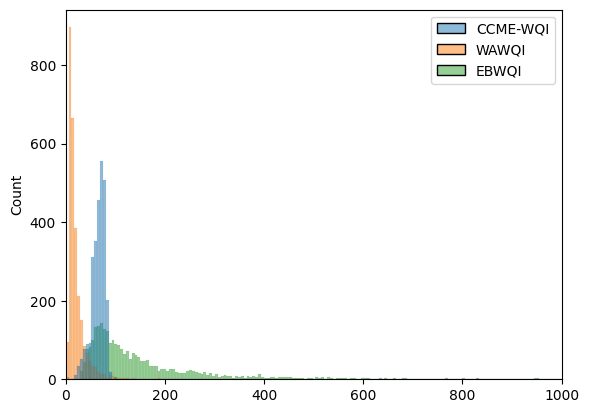

In [15]:
sns.histplot(results)
sns.set_palette('Pastel2')
plt.xlim(0, 1000)

## Regression

In [17]:
# import all other regression models available in different libraries
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

# import metrics to evaluate the models
from sklearn.model_selection import cross_val_score, KFold

In [18]:
# create a dictionary for model names and model objects

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Elastic Net': ElasticNet(),
    'K Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Support Vector Machine': SVR(),
    'Ada Boost': AdaBoostRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gaussian Process': GaussianProcessRegressor(),
    'Kernel Ridge': KernelRidge(),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=False),
    'LightGBM': LGBMRegressor(),
    'Multi Layer Perceptron': MLPRegressor()
}

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def correlation_coefficient(observed, predicted):
    return np.corrcoef(observed, predicted)[0, 1]

def root_mean_square_error(observed, predicted):
    return np.sqrt(mean_squared_error(observed, predicted))

def nash_sutcliffe_efficiency(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    return 1 - (numerator / denominator)

def index_of_agreement(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((np.abs(predicted - mean_observed) +
                          np.abs(observed - mean_observed)) ** 2)
    return 1 - (numerator / denominator)

In [20]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

wqi = pd.concat([data, results], axis=1)
wqi = wqi.dropna()
features = ['PH','EC','TDS','ALK','TH', 'F','CL','NO3','SO4','CA','MG']

X = wqi[features]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=features)

y1 = wqi['WAWQI']
y2 = wqi['EBWQI']
y3 = wqi['CCME-WQI']

X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

# Create a dictionary to store results
results_dict = {'Model': [], 'Target': [], 'Metric': [], 'Metric Value': [], 'y_test': [], 'y_pred': []}

# Metrics to calculate
metrics = {
    'MSE': mean_squared_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'MAE': mean_absolute_error,
    'R2': r2_score,
    'NSE': lambda y_true, y_pred: 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
}

# Loop through models
for name, model in tqdm(models.items()):
    for target_name, target_train, target_test in [('WAWQI', y1_train, y1_test), ('EBWQI', y2_train, y2_test), ('CCME-WQI', y3_train, y3_test)]:
        for metric_name, metric_func in metrics.items():
            # Train the model
            model.fit(X_train, target_train)

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Calculate the metric value
            metric_value = metric_func(target_test, y_pred)

            # Store results in the dictionary
            results_dict['Model'].append(name)
            results_dict['Target'].append(target_name)
            results_dict['Metric'].append(metric_name)
            results_dict['Metric Value'].append(metric_value)
            results_dict['y_test'].append(target_test)
            results_dict['y_pred'].append(y_pred)


# Create a DataFrame
regression_results_df = pd.DataFrame(results_dict)

# Pivot the DataFrame
comparison_df_reg = regression_results_df.pivot(index='Target', columns=['Metric','Model'], values='Metric Value')

# Print the comparison DataFrame
comparison_df_reg.style.background_gradient(cmap='Greens', axis=None)

  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [01:08<00:00,  4.04s/it]


Metric,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE,MSE,RMSE,MAE,R2,NSE
Model,Linear Regression,Linear Regression,Linear Regression,Linear Regression,Linear Regression,Ridge,Ridge,Ridge,Ridge,Ridge,Lasso,Lasso,Lasso,Lasso,Lasso,Elastic Net,Elastic Net,Elastic Net,Elastic Net,Elastic Net,K Nearest Neighbors,K Nearest Neighbors,K Nearest Neighbors,K Nearest Neighbors,K Nearest Neighbors,Decision Tree,Decision Tree,Decision Tree,Decision Tree,Decision Tree,Support Vector Machine,Support Vector Machine,Support Vector Machine,Support Vector Machine,Support Vector Machine,Ada Boost,Ada Boost,Ada Boost,Ada Boost,Ada Boost,Gradient Boosting,Gradient Boosting,Gradient Boosting,Gradient Boosting,Gradient Boosting,Extra Trees,Extra Trees,Extra Trees,Extra Trees,Extra Trees,Random Forest,Random Forest,Random Forest,Random Forest,Random Forest,Gaussian Process,Gaussian Process,Gaussian Process,Gaussian Process,Gaussian Process,Kernel Ridge,Kernel Ridge,Kernel Ridge,Kernel Ridge,Kernel Ridge,XGBoost,XGBoost,XGBoost,XGBoost,XGBoost,CatBoost,CatBoost,CatBoost,CatBoost,CatBoost,LightGBM,LightGBM,LightGBM,LightGBM,LightGBM,Multi Layer Perceptron,Multi Layer Perceptron,Multi Layer Perceptron,Multi Layer Perceptron,Multi Layer Perceptron
Target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCME-WQI,104.422577,10.218737,8.358986,0.373992,0.373992,104.105517,10.203211,8.333087,0.375893,0.375893,103.679779,10.182327,8.492353,0.378445,0.378445,102.442721,10.121399,8.495311,0.385861,0.385861,21.553315,4.642555,3.440058,0.870789,0.870789,17.090816,4.062569,2.502532,0.897352,0.901865,34.112523,5.840593,4.580079,0.795497,0.795497,25.168533,5.178381,4.067452,0.841161,0.861858,4.018549,2.005325,1.408509,0.975908,0.975924,11.720616,3.323820,2.500257,0.928996,0.931012,10.139355,3.156284,2.113974,0.938321,0.939500,11748.381236,108.389950,50.818323,-69.430964,-69.430964,4513.840284,67.185120,66.311613,-26.060249,-26.060249,4.384865,2.094007,1.233405,0.973713,0.973713,1.632449,1.277673,0.731567,0.990214,0.990214,3.430371,1.852126,1.175845,0.979435,0.979435,68.959902,8.279626,6.542212,0.608644,0.601897
EBWQI,0.000000,0.000000,0.000000,1.000000,1.000000,0.041287,0.203191,0.041952,0.999999,0.999999,11.181401,3.343860,1.641511,0.999600,0.999600,552.098751,23.496782,11.786751,0.980256,0.980256,1781.343192,42.205962,13.677602,0.936296,0.936296,793.248257,28.611806,11.550397,0.977982,0.970302,17313.097921,131.579246,34.587783,0.380853,0.380853,1726.656270,36.429842,28.602662,0.962011,0.948682,174.089074,13.756794,5.242905,0.992610,0.993199,230.397146,14.918021,5.251411,0.991227,0.992655,280.918840,15.569259,6.116336,0.989681,0.988794,27316.668282,165.277549,37.198803,0.023107,0.023107,27939.419011,167.150887,167.006466,0.000836,0.000836,607.116003,24.639724,6.421010,0.978288,0.978288,226.613939,15.053702,4.493916,0.991896,0.991896,2051.961698,45.298584,11.949905,0.926618,0.926618,631.065412,25.226743,16.731737,0.971574,0.980647
WAWQI,0.000000,0.000000,0.000000,1.000000,1.000000,0.000594,0.024376,0.008355,0.999998,0.999998,3.018054,1.737255,1.159741,0.991537,0.991537,7.735711,2.781315,1.613856,0.978308,0.978308,19.928810,4.464170,1.475172,0.944118,0.944118,11.264628,3.734464,1.355359,0.970185,0.965434,147.135977,12.129962,2.284032,0.587415,0.587415,16.378421,4.115944,3.303029,0.953667,0.953972,1.852184,1.379873,0.621907,0.994840,0.994452,2.272539,1.511297,0.684433,0.992582,0.992358,2.932674,1.780477,0.805087,0.992082,0.992784,352.976523,18.787669,4.304977,0.010217,0.010217,421.524504,20.531062,20.513843,-0.181999,-0.181999,7.703188,2.775462,0.773397,0.978399,0.978399,1.657923,1.287604,0.423869,0.995351,0.995351,16.396871,4.049305,1.129372,0.954021,0.954021,0.33

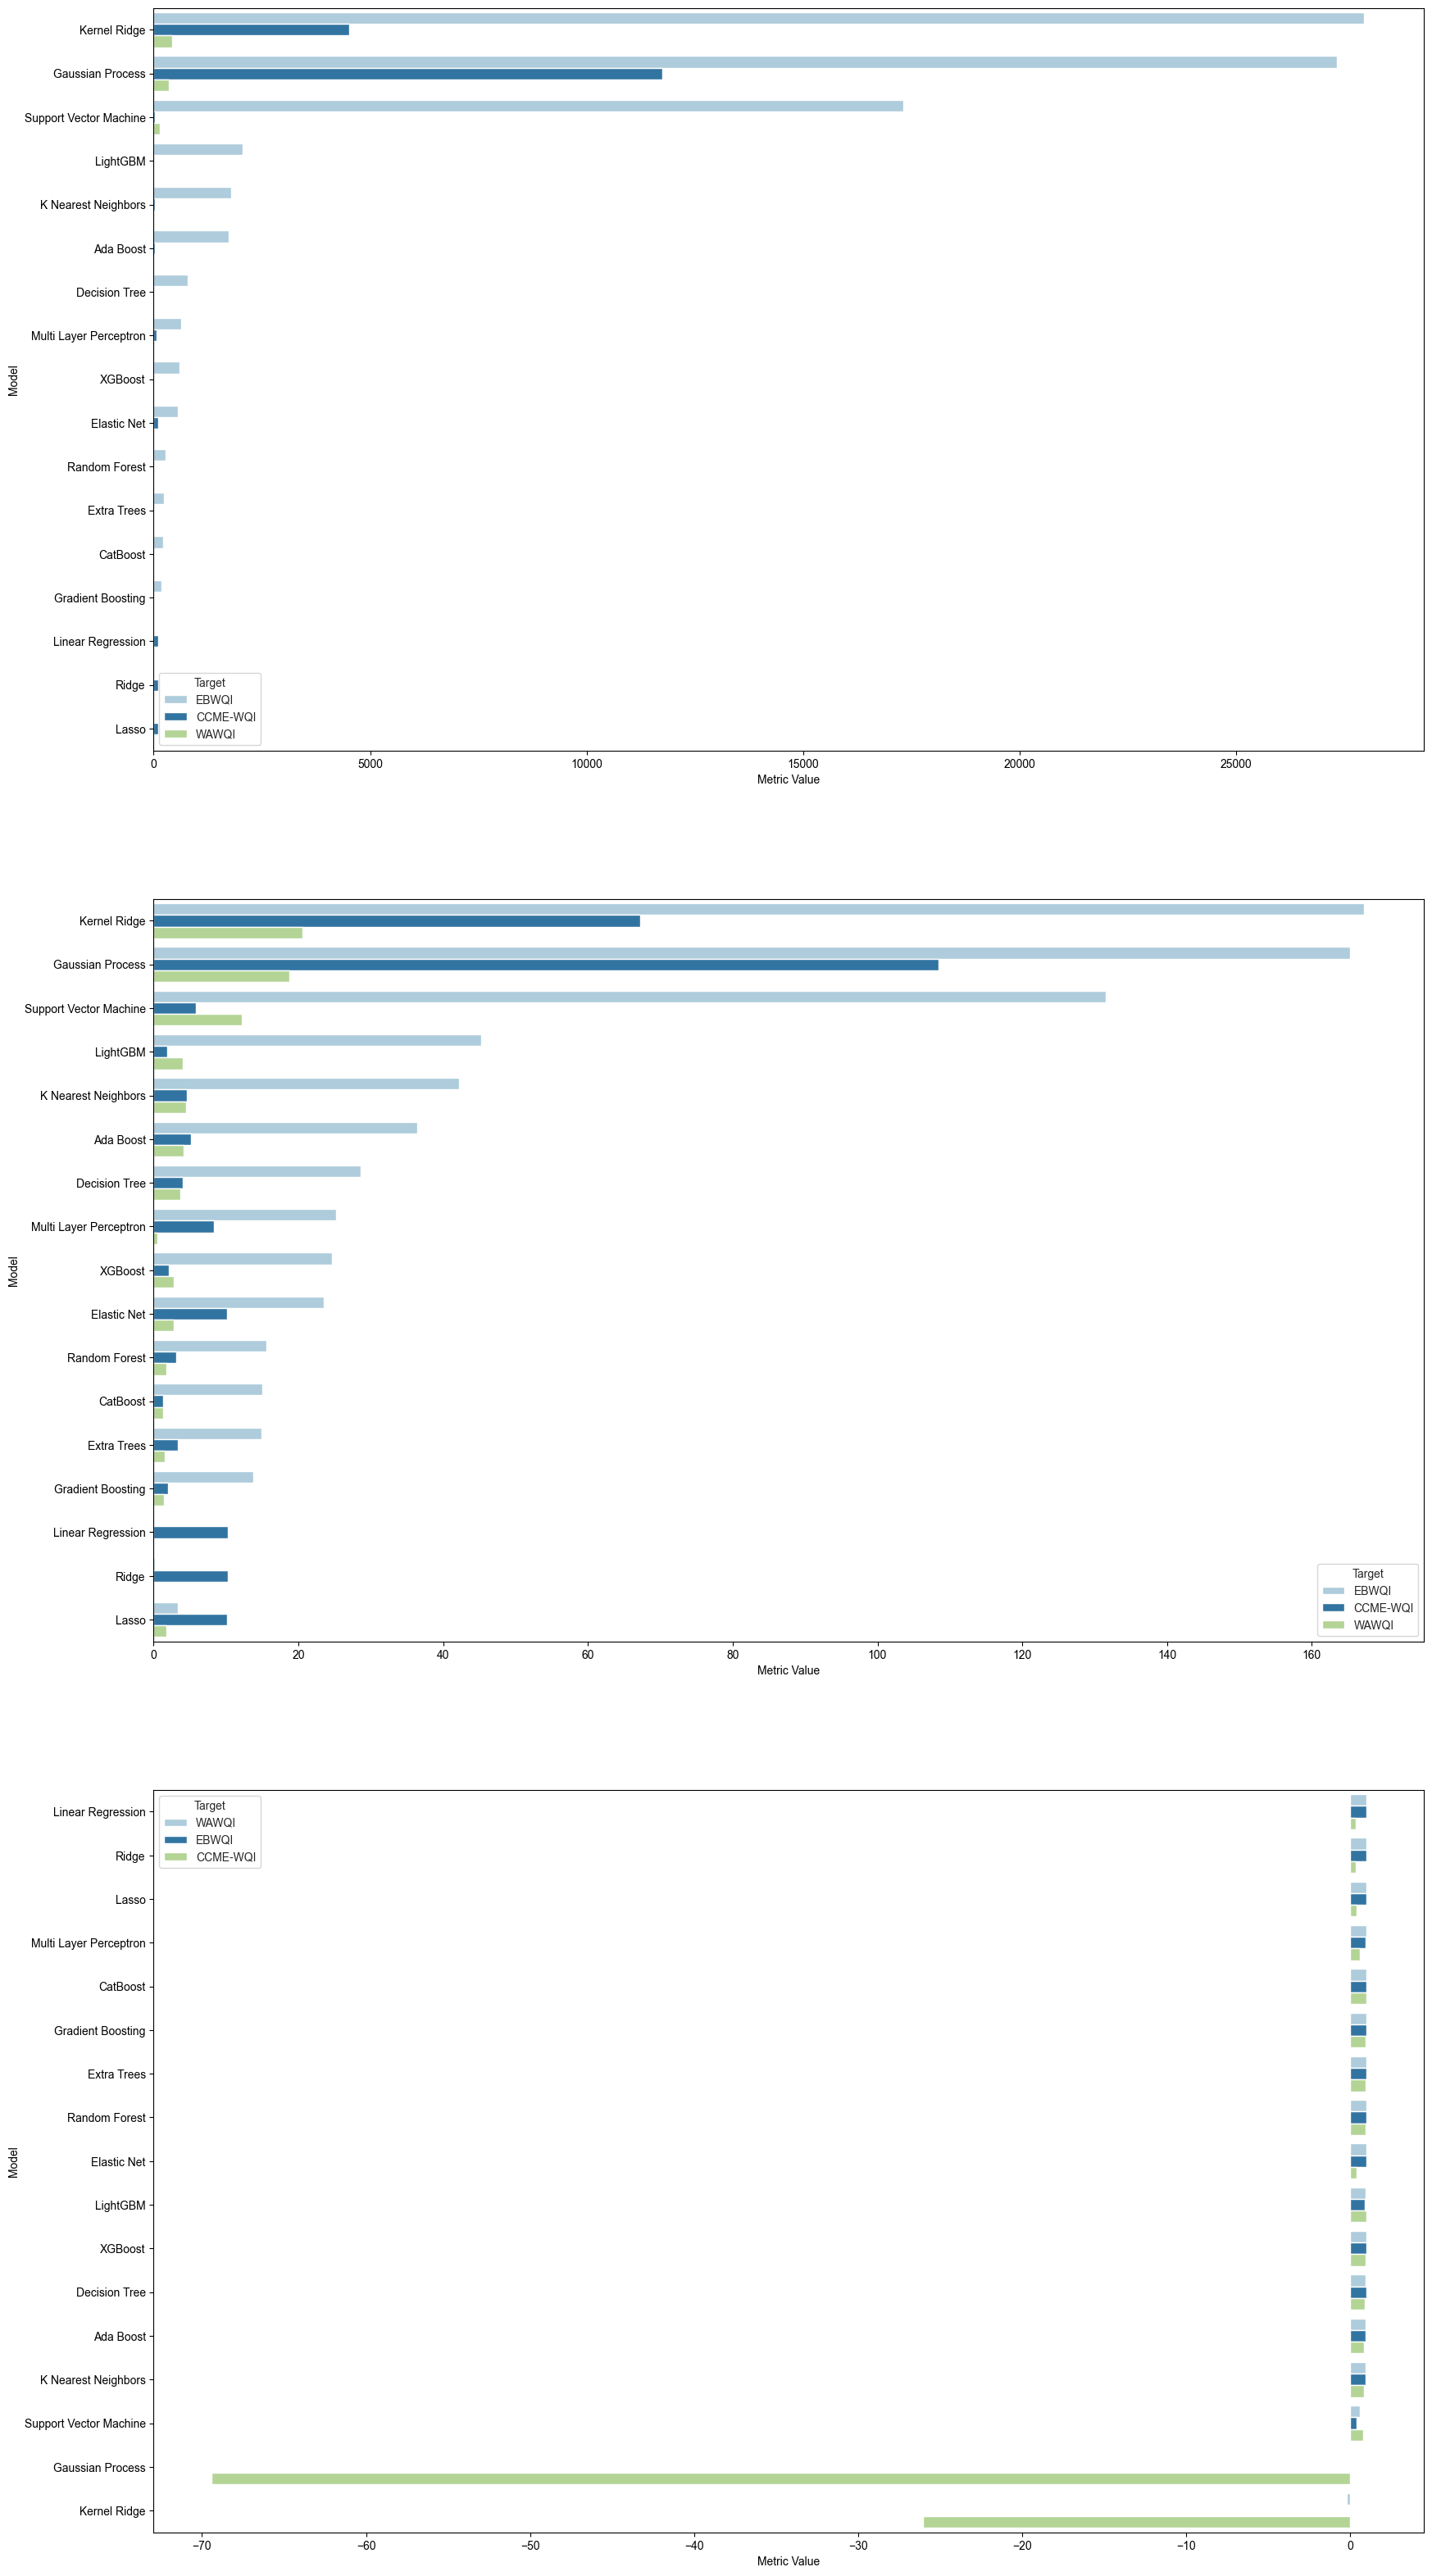

In [21]:
fig, axes = plt.subplots(3, 1, figsize=(20, 40))
sns.set_style('whitegrid')
sns.set_palette('Paired')
for ax, metric in zip(axes.flatten(), ['MSE','RMSE','R2']):
    sns.barplot(data=regression_results_df[regression_results_df['Metric'] == metric].sort_values(by="Metric Value", ascending=False), x='Metric Value', y='Model', hue='Target', ax=ax, orient='h', palette='Paired')

In [22]:
regression_results_df[regression_results_df['Metric'] == 'R2'].sort_values(by='Metric Value', ascending=False).head(10)

,Model,Target,Metric,Metric Value,y_test,y_pred
3,Linear Regression,WAWQI,R2,1.000000,861 13.067073 946 19.797631 1095 7...,"[13.06707333333334, 19.797631111111112, 7.9710..."
8,Linear Regression,EBWQI,R2,1.000000,861 102.166608 946 149.602121 1095 ...,"[102.1666079295984, 149.60212091428284, 62.284..."
23,Ridge,EBWQI,R2,0.999999,861 102.166608 946 149.602121 1095 ...,"[102.19639523570396, 149.65364370031708, 62.28..."
18,Ridge,WAWQI,R2,0.999998,861 13.067073 946 19.797631 1095 7...,"[13.05843377556382, 19.794388125478672, 7.9726..."
38,Lasso,EBWQI,R2,0.999600,861 102.166608 946 149.602121 1095 ...,"[104.81274857207984, 151.03989904942716, 63.22..."
243,Multi Layer Perceptron,WAWQI,R2,0.999309,861 13.067073 946 19.797631 1095 7...,"[12.30713565305603, 20.44100748003565, 7.93494..."
213,CatBoost,WAWQI,R2,0.995351,861 13.067073 946 19.797631 1095 7...,"[12.52734902807027, 20.075832487395793, 7.8615..."
123,Gradient Boosting,WAWQI,R2,0.994840,861 13.067073 946 19.797631 1095 7...,"[13.46244393984821, 19.49889181278437, 7.83733..."
128,Gradient Boosting,EBWQI,R2,0.992610,861 102.166608 946 149.602121 1095 ...,"[101.50283789243005, 156.06074322163553, 64.83..."
138,Extra Trees,WAWQI,R2,0.992582,861 13.067073 946 19.797631 1095 7...,"[13.635847722222225, 19.677659611111103, 7.910..."


In [23]:
regression_results_df[regression_results_df['Metric'] == 'MSE'].sort_values(by='Metric Value', ascending=True).head(10)

,Model,Target,Metric,Metric Value,y_test,y_pred
0,Linear Regression,WAWQI,MSE,6.458406e-28,861 13.067073 946 19.797631 1095 7...,"[13.06707333333334, 19.797631111111112, 7.9710..."
5,Linear Regression,EBWQI,MSE,7.930645e-26,861 102.166608 946 149.602121 1095 ...,"[102.1666079295984, 149.60212091428284, 62.284..."
15,Ridge,WAWQI,MSE,5.942135e-04,861 13.067073 946 19.797631 1095 7...,"[13.05843377556382, 19.794388125478672, 7.9726..."
20,Ridge,EBWQI,MSE,4.128674e-02,861 102.166608 946 149.602121 1095 ...,"[102.19639523570396, 149.65364370031708, 62.28..."
240,Multi Layer Perceptron,WAWQI,MSE,3.300808e-01,861 13.067073 946 19.797631 1095 7...,"[12.541556501673277, 20.59712529129802, 7.7508..."
220,CatBoost,CCME-WQI,MSE,1.632449e+00,861 77.674892 946 70.838787 1095 61...,"[77.91254575260332, 70.26093904171007, 61.3790..."
210,CatBoost,WAWQI,MSE,1.657923e+00,861 13.067073 946 19.797631 1095 7...,"[12.52734902807027, 20.075832487395793, 7.8615..."
120,Gradient Boosting,WAWQI,MSE,1.852184e+00,861 13.067073 946 19.797631 1095 7...,"[13.462443939848212, 19.49889181278437, 7.8373..."
135,Extra Trees,WAWQI,MSE,2.272539e+00,861 13.067073 946 19.797631 1095 7...,"[13.545551466666666, 19.559063633333338, 7.900..."
150,Random Forest,WAWQI,MSE,2.932674e+00,861 13.067073 946 19.797631 1095 7...,"[13.559043099999997, 19.3733437, 7.99996066666..."


### Regression Results

In [24]:
for model in ['Linear Regression', 'XGBoost', 'CatBoost', 'LightGBM', 'Random Forest']:
    print(regression_results_df[(regression_results_df['Model'] == model) & (regression_results_df['Metric'] == 'R2')])

                Model    Target Metric  Metric Value  \
3   Linear Regression     WAWQI     R2      1.000000   
8   Linear Regression     EBWQI     R2      1.000000   
13  Linear Regression  CCME-WQI     R2      0.373992   

                                               y_test  \
3   861     13.067073
946     19.797631
1095     7...   
8   861     102.166608
946     149.602121
1095    ...   
13  861     77.674892
946     70.838787
1095    61...   

                                               y_pred  
3   [13.06707333333334, 19.797631111111112, 7.9710...  
8   [102.1666079295984, 149.60212091428284, 62.284...  
13  [69.21101222865681, 68.09870597115538, 70.1855...  
       Model    Target Metric  Metric Value  \
198  XGBoost     WAWQI     R2      0.978399   
203  XGBoost     EBWQI     R2      0.978288   
208  XGBoost  CCME-WQI     R2      0.973713   

                                                y_test  \
198  861     13.067073
946     19.797631
1095     7...   
203  861     102.

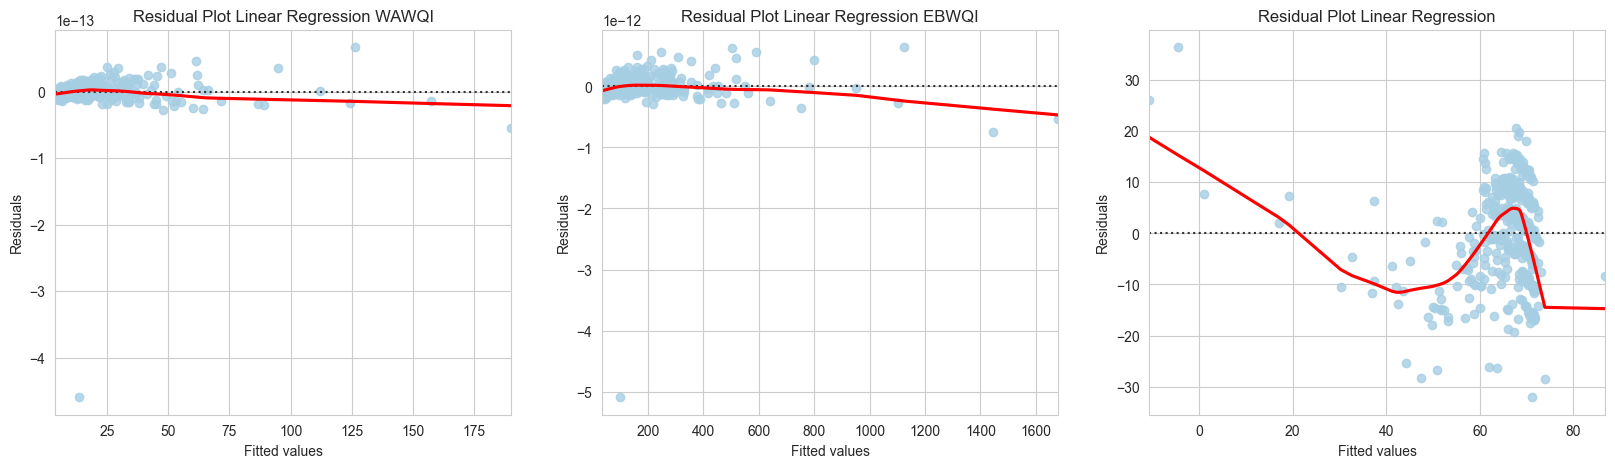

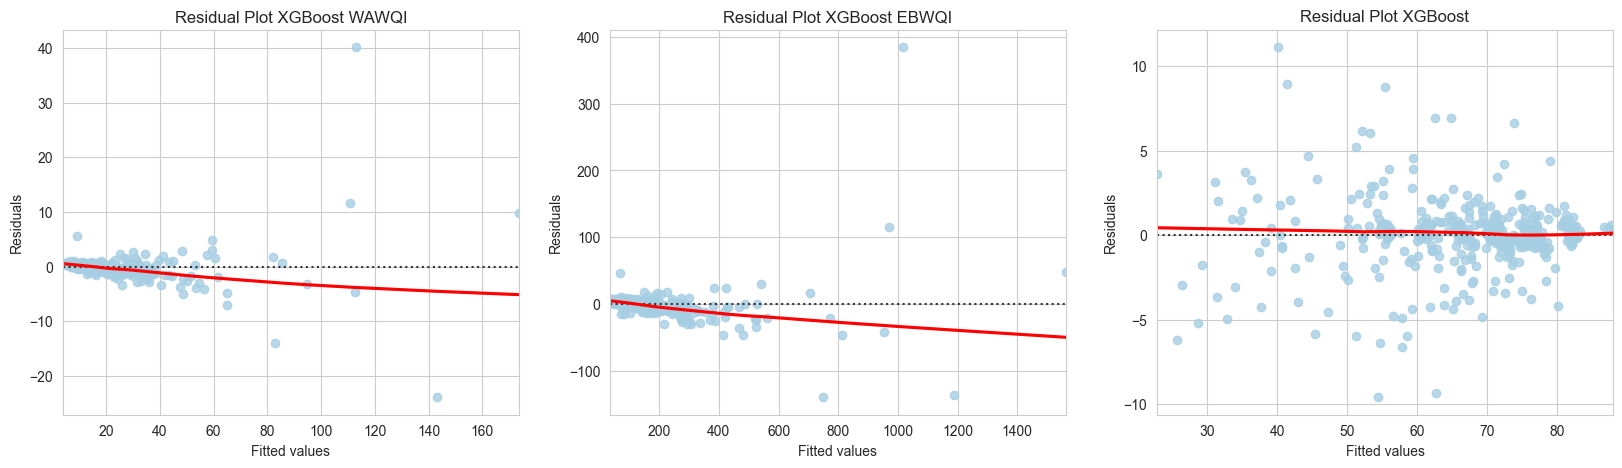

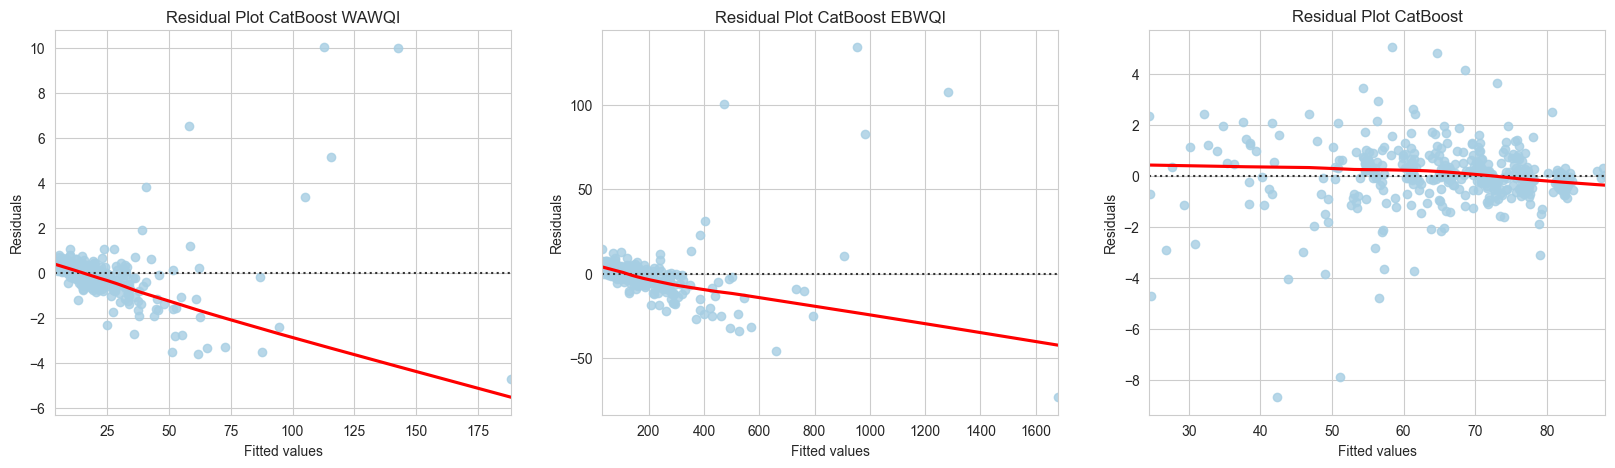

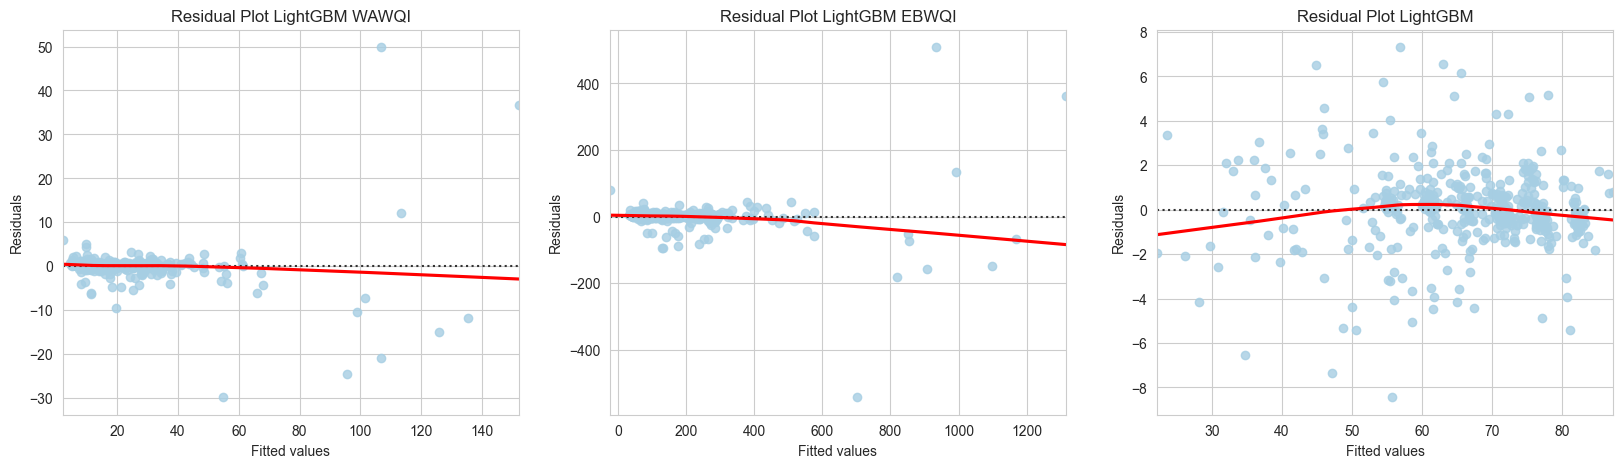

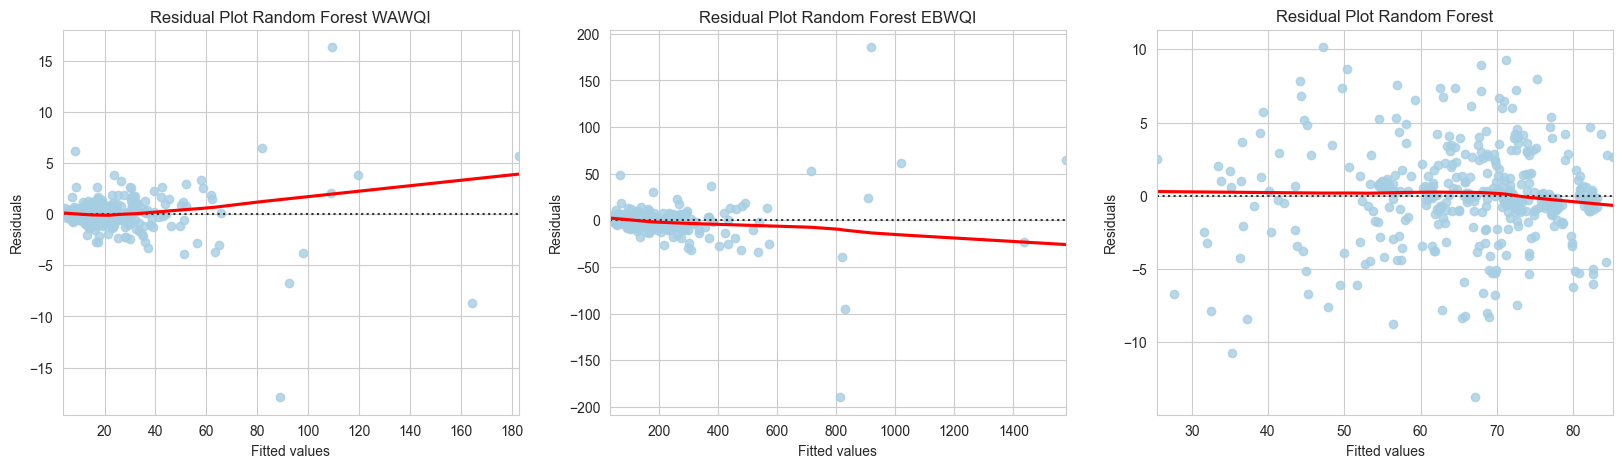

In [25]:
for model in ['Linear Regression', 'XGBoost', 'CatBoost', 'LightGBM', 'Random Forest']:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ax, target in zip(axes.flatten(), ['WAWQI', 'EBWQI', 'CCME-WQI']):
        resid_plot_df = regression_results_df[(regression_results_df['Model'] == model) & (regression_results_df['Metric'] == 'R2') & (regression_results_df['Target'] == target)]
        resid_plot_df['residuals'] = resid_plot_df['y_test'] - resid_plot_df['y_pred']
        sns.residplot(x=resid_plot_df['y_pred'].values[0], y=resid_plot_df['residuals'].values[0].values, lowess=True, line_kws={'color': 'red'}, ax=ax)
        ax.set_xlabel("Fitted values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot {model} {resid_plot_df['Target'].values[0]}")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot {model}")

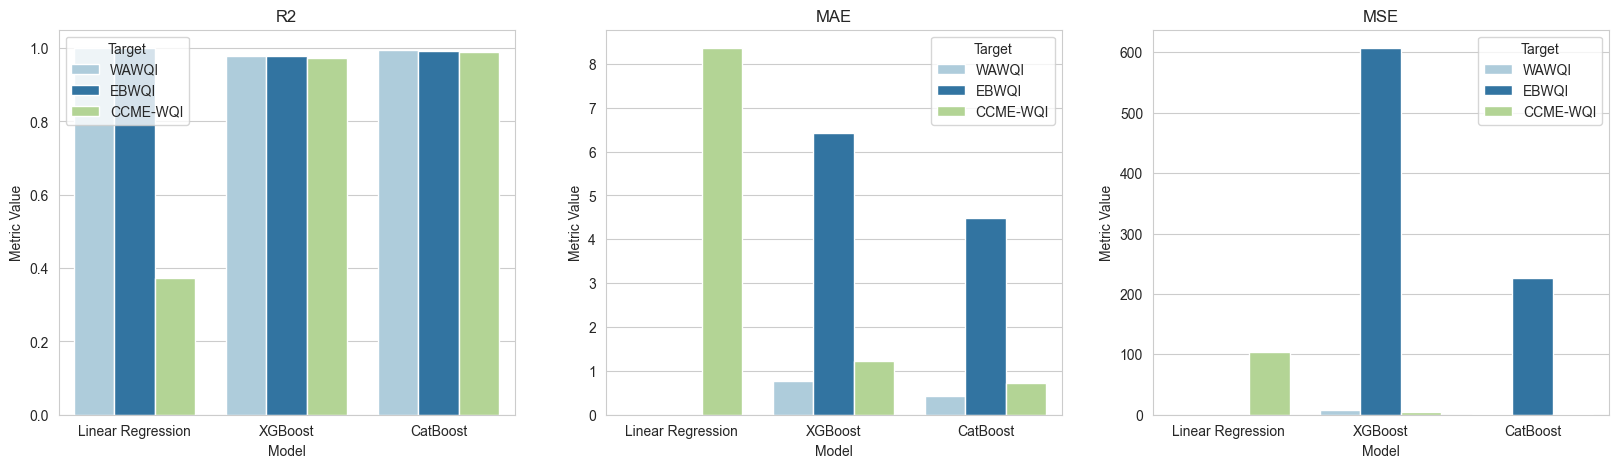

In [26]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

i = 0
ax = axes.flatten()
for metric in ['R2','MAE','MSE']:
        regression_results_df_tmp = regression_results_df[(regression_results_df['Model'].isin(['Linear Regression','XGBoost','CatBoost'])) & (regression_results_df['Metric'] == metric)]
        sns.barplot(data=regression_results_df_tmp, x='Model', y='Metric Value', hue='Target', ax=ax[i])
        ax[i].set_title(f'{metric}')
        i+=1

## Classification

In [27]:
wqi

,PH,EC,TDS,TH,CA,MG,NA,K,CO3,HCO3,CL,NO3,SO4,F,ALK,SAR,CCME-WQI,WAWQI,EBWQI
578,7.14,576.0,385.92,190.0,56.0,12.0,41.0,10.1,0.0,256.0,43.0,10.00,11.0,0.665,210.0,1.29,60.981116,6.810809,45.414326
579,7.34,2877.0,1927.59,480.0,156.0,22.0,386.0,75.0,0.0,1013.0,319.0,68.00,65.0,0.712,830.0,7.66,62.634278,26.596034,184.728149
580,7.55,6170.0,4133.90,1200.0,300.0,109.0,820.0,37.3,0.0,1501.0,667.0,68.00,560.0,1.182,1230.0,10.29,36.013377,54.157678,395.460670
581,7.74,820.0,549.40,210.0,52.0,19.0,98.0,0.6,0.0,281.0,99.0,48.00,10.0,0.834,230.0,2.94,66.374236,9.778067,74.847613
582,7.84,2892.0,1937.64,430.0,104.0,41.0,460.0,3.4,0.0,390.0,787.0,4.00,5.0,0.720,320.0,9.64,80.845208,22.727862,184.141567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,7.42,768.0,515.00,180.0,40.0,19.0,95.0,10.0,0.0,183.0,113.0,3.20,70.0,0.150,150.0,3.08,60.989717,7.274778,55.265419
2760,7.73,4419.0,2961.00,701.0,96.0,112.0,712.0,17.0,0.0,403.0,1064.0,13.00,310.0,0.780,330.0,11.70,57.180425,34.582556,287.693326
2761,7.60,2942.0,1971.00,400.0,132.0,17.0,552.0,26.0,0.0,281.0,567.0,33.00,538.0,0.930,230.0,12.00,75.149894,23.527667,196.800919
2762,7.35,1464.0,981.00,410.0,104.0,36.0,125.0,18.0,0.0,610.0,142.0,0.31,25.0,1.040,500.0,2.68,87.842858,15.582556,103.042516


In [28]:
def create_categorical_wqi(df):
    df['WAWQI_classif'] = df['WAWQI'].apply(lambda x: 'Undrinkable' if x >= 100 else ('Very Poor' if x >= 76 else ('Poor' if x >= 51 else ('Good' if x >= 26 else 'Excellent'))))
    df['WAWQI_encoded'] = df['WAWQI'].apply(lambda x: 0 if x >= 100 else (1 if x >= 76 else (2 if x >= 51 else (3 if x >= 26 else 4))))

    df['EBWQI_classif'] = df['EBWQI'].apply(lambda x: 'Undrinkable' if x >= 100 else ('Very Poor' if x >= 76 else ('Poor' if x >= 51 else ('Good' if x >= 26 else 'Excellent'))))
    df['EBWQI_encoded'] = df['EBWQI'].apply(lambda x: 0 if x >= 100 else (1 if x >= 76 else (2 if x >= 51 else (3 if x >= 26 else 4))))

    df['CCME-WQI_classif'] = df['CCME-WQI'].apply(lambda x: 'Excellent' if x >= 95 else ('Good' if x >= 80 else ('Fair' if x >= 65 else ('Marginal' if x >= 45 else 'Poor'))))
    df['CCME-WQI_encoded'] = df['CCME-WQI'].apply(lambda x: 4 if x >= 95 else (3 if x >= 80 else (2 if x >= 65 else (1 if x >= 45 else 1))))

create_categorical_wqi(wqi)

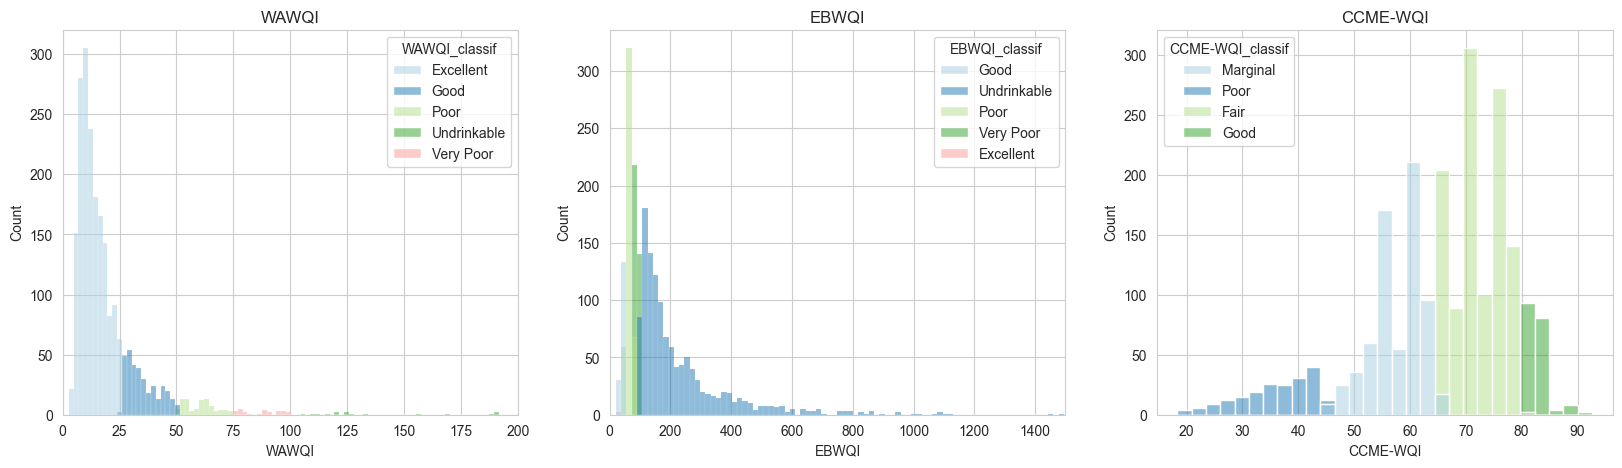

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, col in enumerate(['WAWQI','EBWQI','CCME-WQI']):
    sns.histplot(data=wqi, x=col, hue=col+'_classif', ax=ax[i])
    ax[i].set_title(col)
    if (col=='WAWQI'):
        ax[i].set_xlim(0, 200)
    if (col=='EBWQI'):
        ax[i].set_xlim(0, 1500)
    ax[i].set_xlim()

In [30]:
wqi

,PH,EC,TDS,TH,CA,MG,NA,K,CO3,HCO3,...,SAR,CCME-WQI,WAWQI,EBWQI,WAWQI_classif,WAWQI_encoded,EBWQI_classif,EBWQI_encoded,CCME-WQI_classif,CCME-WQI_encoded
578,7.14,576.0,385.92,190.0,56.0,12.0,41.0,10.1,0.0,256.0,...,1.29,60.981116,6.810809,45.414326,Excellent,4,Good,3,Marginal,1
579,7.34,2877.0,1927.59,480.0,156.0,22.0,386.0,75.0,0.0,1013.0,...,7.66,62.634278,26.596034,184.728149,Good,3,Undrinkable,0,Marginal,1
580,7.55,6170.0,4133.90,1200.0,300.0,109.0,820.0,37.3,0.0,1501.0,...,10.29,36.013377,54.157678,395.460670,Poor,2,Undrinkable,0,Poor,1
581,7.74,820.0,549.40,210.0,52.0,19.0,98.0,0.6,0.0,281.0,...,2.94,66.374236,9.778067,74.847613,Excellent,4,Poor,2,Fair,2
582,7.84,2892.0,1937.64,430.0,104.0,41.0,460.0,3.4,0.0,390.0,...,9.64,80.845208,22.727862,184.141567,Excellent,4,Undrinkable,0,Good,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759,7.42,768.0,515.00,180.0,40.0,19.0,95.0,10.0,0.0,183.0,...,3.08,60.989717,7.274778,55.265419,Excellent,4,Poor,2,Marginal,1
2760,7.73,4419.0,2961.00,701.0,96.0,112.0,712.0,17.0,0.0,403.0,...,11.70,57.180425,34.582556,287.693326,Good,3,Undrinkable,0,Marginal,1
2761,7.60,2942.0,1971.00,400.0,132.0,17.0,552.0,26.0,0.0,281.0,...,12.00,75.149894,23.527667,196.800919,Excellent,4,Undrinkable,0,Fair,2
2762,7.35,1464.0,981.00,410.0,104.0,36.0,125.0,18.0,0.0,610.0,...,2.68,87.842858,15.582556,103.042516,Excellent,4,Undrinkable,0,Good,3


In [31]:
# create similar code just for classification
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

X = wqi.drop(['WAWQI', 'EBWQI', 'CCME-WQI', 'WAWQI_classif','EBWQI_classif','CCME-WQI_classif','WAWQI_encoded','EBWQI_encoded','CCME-WQI_encoded'], axis=1)
X = StandardScaler().fit_transform(X)

y1 = wqi['WAWQI_encoded']
y2 = wqi['EBWQI_encoded']
y3 = wqi['CCME-WQI_encoded']

X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

class_list = [0,1,2,3,4]

class_count_1 = y1_test.value_counts().values
class_count_2 = y2_test.value_counts().values
class_count_3 = y3_test.value_counts().values

class_weights_1 = compute_class_weight(class_weight='balanced', classes=np.unique(y1), y=y1)
class_weights_2 = compute_class_weight(class_weight='balanced', classes=np.unique(y2), y=y2)
class_weights_3 = compute_class_weight(class_weight='balanced', classes=np.unique(y3), y=y3)

class_weights_dict_1 = {class_label: weight for class_label, weight in zip(class_list, class_weights_1)}
class_weights_dict_2 = {class_label: weight for class_label, weight in zip(class_list, class_weights_2)}
class_weights_dict_3 = {class_label: weight for class_label, weight in zip(class_list, class_weights_3)}

# create a dictionary for model names and model object for multi class classification
models_multi = {
    'Random Forest': [
        RandomForestClassifier(n_estimators=100, random_state=42),
        RandomForestClassifier(n_estimators=100, random_state=42),
        RandomForestClassifier(n_estimators=100, random_state=42)
        ],
    'XGBoost': [
        XGBClassifier(objective='multi:softmax', num_class=5, random_state=42),
        XGBClassifier(objective='multi:softmax', num_class=5, random_state=42),
        XGBClassifier(objective='multi:softmax', num_class=5, random_state=42),
        # XGBClassifier(objective='multi:softmax'),
        # XGBClassifier(objective='multi:softmax'),
        # XGBClassifier(objective='multi:softmax')
        ],
    'CatBoost': [
        CatBoostClassifier(iterations=100, random_state=42, verbose=False),
        CatBoostClassifier(iterations=100, random_state=42, verbose=False),
        CatBoostClassifier(iterations=100, random_state=42, verbose=False),
        ],
    'LightGBM': [
        LGBMClassifier(objective='multiclass', num_class=5, random_state=42),
        LGBMClassifier(objective='multiclass', num_class=5, random_state=42),
        LGBMClassifier(objective='multiclass', num_class=5, random_state=42),
        ],
    # 'Multi Layer Perceptron': MLPClassifier()
}

In [45]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, \
    confusion_matrix, log_loss, matthews_corrcoef, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Create a dictionary to store results
results_dict = {'Model': [], 'Target': [], 'Metric': [], 'Metric Value': [], 'proba': [], 'y_train': [], 'y_test': []}

# create a list of metrics for classification
metrics = {
    # 'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score,
    # 'Cohen\'s Kappa': cohen_kappa_score,
    # 'Confusion Matrix': confusion_matrix,
    # 'Log Loss': log_loss,
    # 'Matthews Correlation Coefficient': matthews_corrcoef,
    # 'ROC AUC Score': roc_auc_score
}

# Loop through models
for name, model in tqdm(models_multi.items()):
    for target_name, target_train, target_test in [('WAWQI', y1_train, y1_test), ('EBWQI', y2_train, y2_test), ('CCME-WQI', y3_train, y3_test)]:
        for metric_name, metric_func in metrics.items():
            # Train the model
            if (target_name=='WAWQI'):
                model1 = model[0]
            elif (target_name=='EBWQI'):
                model1 = model[1]
            else:
                model1 = model[2]
            
            print(f"{name} - {target_name} - {metric_name}")

            if name == 'XGBoost' and target_name == 'CCME-WQI':
                le = LabelEncoder()

                # copy the target variable
                target_train_xgb = target_train.copy()
                target_test_xgb = target_test.copy()

                # replace 1,2,3 with 0,1,2
                target_train_xgb[target_train_xgb == 1] = 0
                target_train_xgb[target_train_xgb == 2] = 1
                target_train_xgb[target_train_xgb == 3] = 2

                target_test_xgb[target_test_xgb == 1] = 0
                target_test_xgb[target_test_xgb == 2] = 1
                target_test_xgb[target_test_xgb == 3] = 2

                model1.fit(X_train, target_train_xgb)
                y_pred_1 = model1.predict(X_test)
                y_proba = model1.predict_proba(X_test)

                metric_value_1 = metric_func(target_test_xgb, y_pred_1, average='macro')

                # Store results in the dictionary
                results_dict['Model'].append(name)
                results_dict['Target'].append(target_name)
                results_dict['Metric'].append(metric_name)
                results_dict['Metric Value'].append(metric_value_1)
                results_dict['proba'].append(y_proba)
                results_dict['y_train'].append(target_train_xgb.values)
                results_dict['y_test'].append(target_test_xgb.values)
                continue

            # for other models
            model1.fit(X_train, target_train)
            y_pred_1 = model1.predict(X_test)
            y_proba = model1.predict_proba(X_test)

            metric_value_1 = metric_func(target_test, y_pred_1, average='macro')

            # Store results in the dictionary
            results_dict['Model'].append(name)
            results_dict['Target'].append(target_name)
            results_dict['Metric'].append(metric_name)
            results_dict['Metric Value'].append(metric_value_1)
            results_dict['proba'].append(y_proba)
            results_dict['y_train'].append(target_train.values)
            results_dict['y_test'].append(target_test.values)

  0%|          | 0/4 [00:00<?, ?it/s]

Random Forest - WAWQI - Precision
Random Forest - WAWQI - Recall
Random Forest - WAWQI - F1 Score
Random Forest - EBWQI - Precision
Random Forest - EBWQI - Recall
Random Forest - EBWQI - F1 Score
Random Forest - CCME-WQI - Precision
Random Forest - CCME-WQI - Recall
Random Forest - CCME-WQI - F1 Score


 25%|██▌       | 1/4 [00:01<00:05,  1.90s/it]

XGBoost - WAWQI - Precision
XGBoost - WAWQI - Recall
XGBoost - WAWQI - F1 Score
XGBoost - EBWQI - Precision
XGBoost - EBWQI - Recall
XGBoost - EBWQI - F1 Score
XGBoost - CCME-WQI - Precision
XGBoost - CCME-WQI - Recall


 50%|█████     | 2/4 [00:03<00:03,  1.55s/it]

XGBoost - CCME-WQI - F1 Score
CatBoost - WAWQI - Precision
CatBoost - WAWQI - Recall
CatBoost - WAWQI - F1 Score
CatBoost - EBWQI - Precision
CatBoost - EBWQI - Recall
CatBoost - EBWQI - F1 Score
CatBoost - CCME-WQI - Precision
CatBoost - CCME-WQI - Recall
CatBoost - CCME-WQI - F1 Score


 75%|███████▌  | 3/4 [00:05<00:02,  2.01s/it]

LightGBM - WAWQI - Precision
LightGBM - WAWQI - Recall
LightGBM - WAWQI - F1 Score
LightGBM - EBWQI - Precision
LightGBM - EBWQI - Recall
LightGBM - EBWQI - F1 Score
LightGBM - CCME-WQI - Precision
LightGBM - CCME-WQI - Recall
LightGBM - CCME-WQI - F1 Score


100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


In [46]:
# Create a DataFrame
df_classif = pd.DataFrame(results_dict)

# Print the DataFrame
df_classif

,Model,Target,Metric,Metric Value,proba,y_train,y_test
0,Random Forest,WAWQI,Precision,0.888781,"[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0....","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ..."
1,Random Forest,WAWQI,Recall,0.867051,"[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0....","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ..."
2,Random Forest,WAWQI,F1 Score,0.848676,"[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0....","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ..."
3,Random Forest,EBWQI,Precision,0.879346,"[[0.77, 0.23, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, ...","[3, 0, 2, 2, 0, 1, 1, 1, 3, 0, 0, 0, 2, 0, 2, ...","[0, 0, 2, 2, 3, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, ..."
4,Random Forest,EBWQI,Recall,0.881530,"[[0.77, 0.23, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, ...","[3, 0, 2, 2, 0, 1, 1, 1, 3, 0, 0, 0, 2, 0, 2, ...","[0, 0, 2, 2, 3, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, ..."
5,Random Forest,EBWQI,F1 Score,0.880027,"[[0.77, 0.23, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, ...","[3, 0, 2, 2, 0, 1, 1, 1, 3, 0, 0, 0, 2, 0, 2, ...","[0, 0, 2, 2, 3, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, ..."
6,Random Forest,CCME-WQI,Precision,0.886311,"[[0.0, 0.9, 0.1], [0.31, 0.49, 0.2], [0.9, 0.1...","[1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, ...","[2, 2, 1, 2, 1, 3, 3, 2, 2, 1, 2, 2, 1, 2, 2, ..."
7,Random Forest,CCME-WQI,Recall,0.797756,"[[0.0, 0.9, 0.1], [0.31, 0.49, 0.2], [0.9, 0.1...","[1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, ...","[2, 2, 1, 2, 1, 3, 3, 2, 2, 1, 2, 2, 1, 2, 2, ..."
8,Random Forest,CCME-WQI,F1 Score,0.828169,"[[0.0, 0.9, 0.1], [0.31, 0.49, 0.2], [0.9, 0.1...","[1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, ...","[2, 2, 1, 2, 1, 3, 3, 2, 2, 1, 2, 2, 1, 2, 2, ..."
9,XGBoost,WAWQI,Precision,0.888781,"[[5.894912e-05, 8.637794e-06, 1.3630979e-05, 7...","[4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ..."


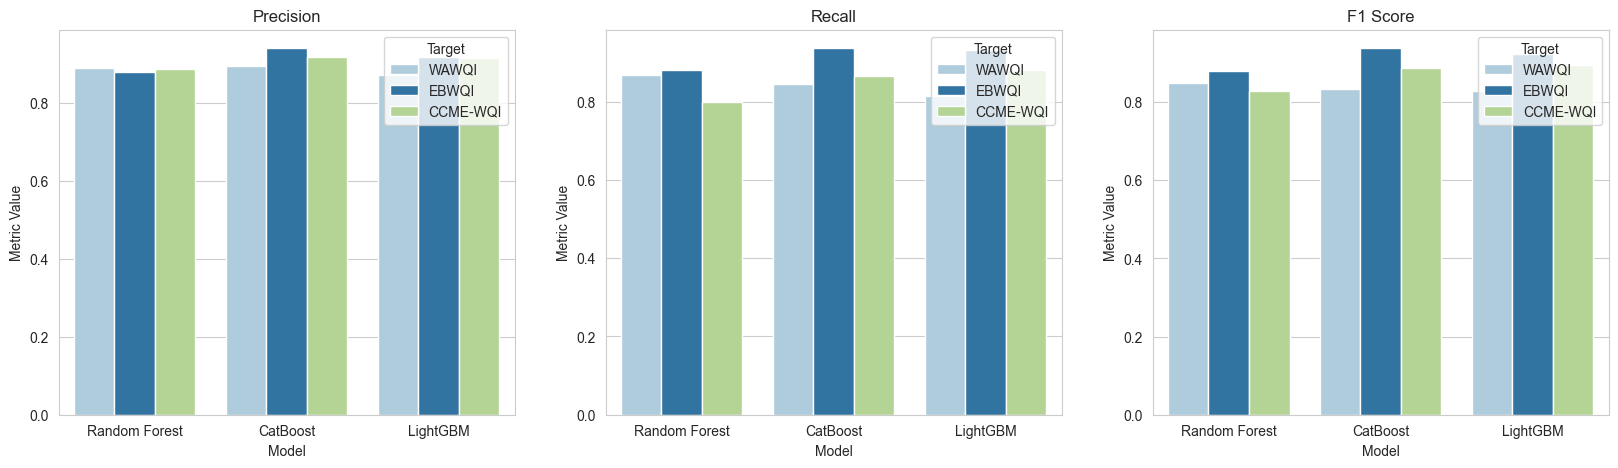

In [47]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

i = 0
ax = axes.flatten()
for metric in ['Precision','Recall','F1 Score']:
        df_filtered = df_classif[(df_classif['Model'].isin(['LightGBM','Random Forest','CatBoost'])) & (df_classif['Metric'] == metric)]
        sns.barplot(data=df_filtered, x='Model', y='Metric Value', hue='Target', ax=ax[i])
        ax[i].set_title(f'{metric}')
        i+=1

In [48]:
for model in ['LightGBM', 'Random Forest', 'CatBoost', 'XGBoost']:
    print(df_classif[(df_classif['Model'] == model) & (df_classif['Metric'] == 'F1 Score')])

       Model    Target    Metric  Metric Value  \
29  LightGBM     WAWQI  F1 Score      0.829621   
32  LightGBM     EBWQI  F1 Score      0.923873   
35  LightGBM  CCME-WQI  F1 Score      0.896022   

                                                proba  \
29  [[1.3497254820220738e-08, 1.273357314291218e-0...   
32  [[0.9963817909886006, 0.0036138669301777524, 3...   
35  [[0.00010525252405354131, 0.999678696514988, 0...   

                                              y_train  \
29  [4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, ...   
32  [3, 0, 2, 2, 0, 1, 1, 1, 3, 0, 0, 0, 2, 0, 2, ...   
35  [1, 2, 2, 2, 1, 2, 2, 3, 1, 2, 2, 1, 2, 2, 1, ...   

                                               y_test  
29  [4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 2, 3, 4, ...  
32  [0, 0, 2, 2, 3, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...  
35  [2, 2, 1, 2, 1, 3, 3, 2, 2, 1, 2, 2, 1, 2, 2, ...  
           Model    Target    Metric  Metric Value  \
2  Random Forest     WAWQI  F1 Score      0.848676   
5  Random

In [53]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

def plot_roc(y_test, y_score):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.figure()
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

for model in ['LightGBM', 'Random Forest', 'CatBoost', 'XGBoost']:
    df = df_classif[(df_classif['Model'] == model) & (df_classif['Metric'] == 'F1 Score')]

    label_binarizer = LabelBinarizer().fit(df['y_train'].values[0])
    y_onehot_test = label_binarizer.transform(df['y_test'].values[0])

    for class_of_interest in range(0,5):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

        plot_roc(y_onehot_test[:, class_id], df['proba'].values[0][:, class_id])


AttributeError: 'dict' object has no attribute 'roc_curve'

## :sparkles: Best Models:
### Regression: CatBoost
### Classification: CatBoost

# :sparkles: Hyperparameter Tuning

In [54]:
X = wqi[features]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=features)

# Regression
y1 = wqi['WAWQI']
y2 = wqi['EBWQI']
y3 = wqi['CCME-WQI']

# Classification
y1_clf = wqi['WAWQI_encoded']
y2_clf = wqi['EBWQI_encoded']
y3_clf = wqi['CCME-WQI_encoded']

# Train test split
X_train_reg, X_test_reg, y1_train_reg, y1_test_reg, y2_train_reg, y2_test_reg, y3_train_reg, y3_test_reg = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

X_train_clf, X_test_clf, y1_train_clf, y1_test_clf, y2_train_clf, y2_test_clf, y3_train_clf, y3_test_clf = train_test_split(X, y1_clf, y2_clf, y3_clf, test_size=0.2, random_state=42)

In [78]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split


def objective_classifier(trial, y_train_clf, y_test_clf):
    # Define the search space for classifier
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'iterations': trial.suggest_int('iterations', 100, 500)
    }

    # Train CatBoost Classifier
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train_clf, y_train_clf)

    # Predict on the test set
    y_pred = model.predict(X_test_clf)

    # Compute accuracy
    accuracy = accuracy_score(y_test_clf, y_pred)

    return accuracy

def objective_regressor(trial, y_train_reg, y_test_reg):
    # Define the search space for regressor
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'iterations': trial.suggest_int('iterations', 100, 500)
    }

    # Train CatBoost Regressor
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train_reg, y_train_reg)

    # Predict on the test set
    y_pred = model.predict(X_test_reg)

    # Compute mean squared error
    mse = mean_squared_error(y_test_reg, y_pred)

    return mse

In [72]:
from functools import partial

def optimize_catboost_regressor():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(objective_regressor, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

In [79]:
def optimize_catboost_classifier():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_clf, y2_train_clf, y3_train_clf], [y1_test_clf, y2_test_clf, y3_test_clf]):
        study_classifier = optuna.create_study(direction='maximize')
        objective_with_args = partial(objective_classifier, y_train_clf=y_train, y_test_clf=y_test)
        study_classifier.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for classifier
        print(f"Best Parameters for Classifier {method}:", study_classifier.best_params)

        # Get the best CatBoost classifier
        best_catboost_classifier = CatBoostClassifier(**study_classifier.best_params, verbose=0)
        best_catboost_classifier.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_clf = best_catboost_classifier.predict(X_test_clf)

        # Compute mean squared error
        accuracy_clf = accuracy_score(y_test, y_pred_clf)
        print(f"Accuracy for Classifier {method}", accuracy_clf)

        best_params[method] = study_classifier.best_params
    
    return best_params

In [74]:
best_catboost_regressor_params = optimize_catboost_regressor()

[I 2024-04-17 22:08:06,517] A new study created in memory with name: no-name-71386424-4c99-49d7-b2d8-ab684fad57c1
[I 2024-04-17 22:08:07,040] Trial 0 finished with value: 8.070645796731375 and parameters: {'learning_rate': 0.05004139230433443, 'depth': 8, 'iterations': 263}. Best is trial 0 with value: 8.070645796731375.
[I 2024-04-17 22:08:08,650] Trial 1 finished with value: 17.577618627152177 and parameters: {'learning_rate': 0.028832424148657127, 'depth': 10, 'iterations': 306}. Best is trial 0 with value: 8.070645796731375.
[I 2024-04-17 22:08:09,667] Trial 2 finished with value: 13.779695078905684 and parameters: {'learning_rate': 0.09840709322588256, 'depth': 10, 'iterations': 186}. Best is trial 0 with value: 8.070645796731375.
[I 2024-04-17 22:08:10,410] Trial 3 finished with value: 8.349149165713312 and parameters: {'learning_rate': 0.1014671181891692, 'depth': 8, 'iterations': 399}. Best is trial 0 with value: 8.070645796731375.
[I 2024-04-17 22:08:10,972] Trial 4 finished w

Best Parameters for Regressor WAWQI: {'learning_rate': 0.1107141022896784, 'depth': 7, 'iterations': 460}


[I 2024-04-17 22:08:19,132] A new study created in memory with name: no-name-fb64d0ec-1cc4-4ac7-9da2-a01a1474dd36


Mean Squared Error for Regressor WAWQI: 5.9240873343736595


[I 2024-04-17 22:08:21,175] Trial 0 finished with value: 866.0929405974224 and parameters: {'learning_rate': 0.0406976772403253, 'depth': 10, 'iterations': 402}. Best is trial 0 with value: 866.0929405974224.
[I 2024-04-17 22:08:21,490] Trial 1 finished with value: 1159.1736695349928 and parameters: {'learning_rate': 0.024554275345009792, 'depth': 6, 'iterations': 334}. Best is trial 0 with value: 866.0929405974224.
[I 2024-04-17 22:08:21,750] Trial 2 finished with value: 309.40346652222127 and parameters: {'learning_rate': 0.14599836389947415, 'depth': 5, 'iterations': 421}. Best is trial 2 with value: 309.40346652222127.
[I 2024-04-17 22:08:21,960] Trial 3 finished with value: 512.1658330125874 and parameters: {'learning_rate': 0.16065037382119993, 'depth': 7, 'iterations': 176}. Best is trial 2 with value: 309.40346652222127.
[I 2024-04-17 22:08:22,284] Trial 4 finished with value: 9152.920373378562 and parameters: {'learning_rate': 0.013454665614684662, 'depth': 8, 'iterations': 17

Best Parameters for Regressor EBWQI: {'learning_rate': 0.11367872962011943, 'depth': 4, 'iterations': 324}
Mean Squared Error for Regressor EBWQI: 209.4554887784038


[I 2024-04-17 22:08:26,862] Trial 0 finished with value: 4.990472460497339 and parameters: {'learning_rate': 0.027588042131937423, 'depth': 8, 'iterations': 323}. Best is trial 0 with value: 4.990472460497339.
[I 2024-04-17 22:08:27,084] Trial 1 finished with value: 10.434807272379789 and parameters: {'learning_rate': 0.016071431042338966, 'depth': 6, 'iterations': 264}. Best is trial 0 with value: 4.990472460497339.
[I 2024-04-17 22:08:27,201] Trial 2 finished with value: 1.7997625891657678 and parameters: {'learning_rate': 0.1901612722157292, 'depth': 5, 'iterations': 185}. Best is trial 2 with value: 1.7997625891657678.
[I 2024-04-17 22:08:27,263] Trial 3 finished with value: 4.044830935218355 and parameters: {'learning_rate': 0.07826412941938987, 'depth': 4, 'iterations': 143}. Best is trial 2 with value: 1.7997625891657678.
[I 2024-04-17 22:08:30,274] Trial 4 finished with value: 5.000700862440482 and parameters: {'learning_rate': 0.02865876458108723, 'depth': 10, 'iterations': 49

Best Parameters for Regressor CCME-WQI: {'learning_rate': 0.13047744725821273, 'depth': 5, 'iterations': 414}
Mean Squared Error for Regressor CCME-WQI: 1.392860711012674


In [80]:
best_catboost_classifier_params = optimize_catboost_classifier()

[I 2024-04-17 22:10:03,001] A new study created in memory with name: no-name-9a4c47e3-dbd7-477e-a024-7899e9d83756
[I 2024-04-17 22:10:07,570] Trial 0 finished with value: 0.9794050343249427 and parameters: {'learning_rate': 0.029197948997099283, 'depth': 9, 'iterations': 340}. Best is trial 0 with value: 0.9794050343249427.
[I 2024-04-17 22:10:18,703] Trial 1 finished with value: 0.9794050343249427 and parameters: {'learning_rate': 0.19683597961289567, 'depth': 10, 'iterations': 432}. Best is trial 0 with value: 0.9794050343249427.
[I 2024-04-17 22:10:18,871] Trial 2 finished with value: 0.965675057208238 and parameters: {'learning_rate': 0.02052843898113881, 'depth': 4, 'iterations': 143}. Best is trial 0 with value: 0.9794050343249427.
[I 2024-04-17 22:10:21,775] Trial 3 finished with value: 0.977116704805492 and parameters: {'learning_rate': 0.01469984345396764, 'depth': 8, 'iterations': 389}. Best is trial 0 with value: 0.9794050343249427.
[I 2024-04-17 22:10:22,563] Trial 4 finish

Best Parameters for Classifier WAWQI: {'learning_rate': 0.13484748770281785, 'depth': 4, 'iterations': 441}


[I 2024-04-17 22:10:26,395] A new study created in memory with name: no-name-afc346d2-1144-4170-9356-9e0c1368d9b3


Accuracy for Classifier WAWQI 0.9839816933638444


[I 2024-04-17 22:10:26,864] Trial 0 finished with value: 0.9244851258581236 and parameters: {'learning_rate': 0.012768317314949706, 'depth': 4, 'iterations': 430}. Best is trial 0 with value: 0.9244851258581236.
[I 2024-04-17 22:10:32,990] Trial 1 finished with value: 0.9473684210526315 and parameters: {'learning_rate': 0.024671921667877735, 'depth': 9, 'iterations': 403}. Best is trial 1 with value: 0.9473684210526315.
[I 2024-04-17 22:10:35,709] Trial 2 finished with value: 0.9519450800915332 and parameters: {'learning_rate': 0.08290503600016343, 'depth': 8, 'iterations': 291}. Best is trial 2 with value: 0.9519450800915332.
[I 2024-04-17 22:10:45,718] Trial 3 finished with value: 0.9496567505720824 and parameters: {'learning_rate': 0.0402347618309005, 'depth': 10, 'iterations': 368}. Best is trial 2 with value: 0.9519450800915332.
[I 2024-04-17 22:10:46,049] Trial 4 finished with value: 0.9519450800915332 and parameters: {'learning_rate': 0.10292435721058397, 'depth': 5, 'iterations

Best Parameters for Classifier EBWQI: {'learning_rate': 0.0642919824362449, 'depth': 10, 'iterations': 458}


[I 2024-04-17 22:11:18,848] A new study created in memory with name: no-name-be965d21-aec5-43a3-9e60-abfab66c3f2c


Accuracy for Classifier EBWQI 0.9588100686498856


[I 2024-04-17 22:11:21,025] Trial 0 finished with value: 0.8718535469107551 and parameters: {'learning_rate': 0.011497320815639768, 'depth': 8, 'iterations': 434}. Best is trial 0 with value: 0.8718535469107551.
[I 2024-04-17 22:11:27,923] Trial 1 finished with value: 0.919908466819222 and parameters: {'learning_rate': 0.19592666375744322, 'depth': 10, 'iterations': 396}. Best is trial 1 with value: 0.919908466819222.
[I 2024-04-17 22:11:35,863] Trial 2 finished with value: 0.8832951945080092 and parameters: {'learning_rate': 0.010967870554787647, 'depth': 10, 'iterations': 406}. Best is trial 1 with value: 0.919908466819222.
[I 2024-04-17 22:11:36,297] Trial 3 finished with value: 0.9107551487414187 and parameters: {'learning_rate': 0.1925455519833318, 'depth': 6, 'iterations': 241}. Best is trial 1 with value: 0.919908466819222.
[I 2024-04-17 22:11:37,314] Trial 4 finished with value: 0.9016018306636155 and parameters: {'learning_rate': 0.04347790966531238, 'depth': 8, 'iterations': 

Best Parameters for Classifier CCME-WQI: {'learning_rate': 0.19592666375744322, 'depth': 10, 'iterations': 396}
Accuracy for Classifier CCME-WQI 0.919908466819222


In [81]:
best_catboost_regressor_params

{'WAWQI': {'learning_rate': 0.1107141022896784, 'depth': 7, 'iterations': 460},
 'EBWQI': {'learning_rate': 0.11367872962011943,
  'depth': 4,
  'iterations': 324},
 'CCME-WQI': {'learning_rate': 0.13047744725821273,
  'depth': 5,
  'iterations': 414}}

In [82]:
best_catboost_classifier_params

{'WAWQI': {'learning_rate': 0.13484748770281785,
  'depth': 4,
  'iterations': 441},
 'EBWQI': {'learning_rate': 0.0642919824362449,
  'depth': 10,
  'iterations': 458},
 'CCME-WQI': {'learning_rate': 0.19592666375744322,
  'depth': 10,
  'iterations': 396}}